<a href="https://colab.research.google.com/github/noahcowan1/S4Mamba_Implementation/blob/Colab-Branch/CowanKatiyar_hw4_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_dir = '/content/drive/MyDrive/Stats305B_FinalProject/'

## Set Color Palette

In [3]:
hiroshige = dict(colors=("#e76254", "#ef8a47", "#f7aa58", "#ffd06f",
                           "#ffe6b7", "#aadce0", "#72bcd5", "#528fad",
                           "#376795", "#1e466e"),
                 order=(6, 2, 9, 3, 7, 5, 1, 10, 4, 8))

monet = dict(colors=("#4e6d58", "#749e89", "#abccbe", "#e3cacf",
                   "#c399a2", "#9f6e71", "#41507b", "#7d87b2",
                   "#c2cae3"),
           order=(2, 5, 8, 3, 4, 9, 1, 6, 7))
kandinsky = dict(colors=("#3b7c70", "#ce9642", "#898e9f", "#3b3a3e"),
                 order=(1, 2, 3, 4))

tara=dict(colors=("#eab1c6", "#d35e17", "#e18a1f", "#e9b109", "#829d44"),
          order=(1, 3, 2, 5, 4))

klimt=dict(colors=("#df9ed4", "#c93f55", "#eacc62", "#469d76", "#3c4b99", "#924099"),
           order=(5, 2, 3, 4, 6, 1))

troy=dict(colors=("#421401", "#6c1d0e", "#8b3a2b", "#c27668",
                  "#7ba0b4", "#44728c", "#235070", "#0a2d46"),
          order=(2, 7, 4, 5, 1, 8, 3, 6))

def get_color(idx, colors_dict=hiroshige):
    """
    Helper function to get a color from the defined color dictionary.
    In order, starting at 0
    """
    return colors_dict['colors'][colors_dict['order'].index(idx+1)]

## Setup

In [1]:
# can take around 30s
%%capture
! pip install datasets #huggingface datasets library
! pip install --upgrade pyarrow
! pip install einops
! pip install mamba-ssm

In [9]:
import math
from math import sqrt
import csv

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import custom_bwd, custom_fwd
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

# hugging face imports
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import sys
import warnings

In [6]:
def get_device():
    if torch.backends.mps.is_available():
        device_func = "mps"
    elif torch.cuda.is_available():
        device_func = "cuda"
    else:
        device_func = "cpu"
    return device_func

In [7]:
torch.manual_seed(305)

device = get_device()
assert device=='mps' or device=='cuda', "you need to change runtime type to GPU"

In [14]:
# hyperparams and helper functions
SMALL_ITERS = 1000
LARGE_ITERS = 2000
context_window_size = 256
chunk_size = 512 # BERT can only take max input size 512 characters

def chunk_string(string, size):
    """
    Splits a string into chunks of a specified size.

    :param string: The string to be chunked.
    :param size: The desired chunk size.
    :return: A list of string chunks.
    """
    return [string[i:i+size] for i in range(0, len(string), size)]

## Part 0: Preprocessing

### 0.1: Loading the dataset

The first step is to actually download the dataset. We will be using a dataset on [huggingface](https://huggingface.co/). You can think of hugging face as the sklearn of deep learning.

The dominant mode for preprocessing textual data is to tokenize it, that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionary where counting numbers map to tokens. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research. For our baseline, we will use a tokenizer that microsoft created for code.

In [9]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('microsoft/CodeBERT-base')

In [10]:
# Load the concatenated data
raw_data = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2024/assignments/hw4/python_corpus_4M.csv", header=None)

In [11]:
# should take around 3 min to load in around 4M tokens
warnings.filterwarnings("ignore")

tokens = torch.tensor([], dtype=torch.long)
for index, row in raw_data.iterrows():
    text = row[0]
    chunks = chunk_string(text, chunk_size)
    n = len(chunks)
    for idx, chunk in enumerate(chunks):
        new_tokens = torch.tensor(tokenizer.encode(chunk, add_special_tokens=True))

        # logic to avoid incorrectly adding in start and end sequence tokens as an artifact of chunking
        if idx == 0:
            tokens = torch.cat((tokens, new_tokens[:-1]), dim=0)
        elif idx == n-1:
            tokens = torch.cat((tokens, new_tokens[1:]), dim=0)
        else:
            tokens = torch.cat((tokens, new_tokens[1:-1]), dim=0)

print(f"{len(tokens)} tokens have been loaded in")

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


4000596 tokens have been loaded in


### Question 0.2: Examining the tokenizer

Let's use the same prompts we used in Part 1:

In [12]:
prompt_1_text = \
"""def newton(eta, N, X, y, gamma, beta=None):
  \"""
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  \"""

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):"""

In [13]:
prompt_2_text = \
"""import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    \"""Performs L2-Norm.\"""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    \"""Computes Euclidean distance.\"""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):"""

Here is what the tokenized output for the prompts looks like

### 0.3: Building our dataloader

There are around 50,000 tokens in the codebert vocab, but we only use around 20,000 of them. To make our lives easier, we just reindex the token indices to go from 1 to around 20,000.

In [14]:
# Get unique elements
extra_tokens = torch.cat((torch.tensor(tokenizer.encode(prompt_1_text, add_special_tokens=True)),
                          torch.tensor(tokenizer.encode(prompt_2_text, add_special_tokens=True))),
                         dim=0)

unique_tokens = torch.unique(torch.cat((tokens, extra_tokens), dim=0))

# Create a mapping from code bert to ids that increment by one
from_code_bert_dict = {element.item(): id for id, element in enumerate(unique_tokens)}

# Create a reverse mapping from ids to code bert token ids
to_code_bert_dict = {id: element for element, id in from_code_bert_dict.items()}

vocab_size = len(unique_tokens)
print(f"there are {vocab_size} distinct tokens in the vocabulary")

# helper functions to move between code bert and simple ids
def from_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of code bert tokens
    Returns:
    a list of simple ids
    """
    tkns = [int(from_code_bert_dict[token]) for token in tkn_lst]
    return tkns


def to_code_bert(tkn_lst):
    """
    Args:
    tkn_lst: a list of simple ids
    Returns:
    a list of code bert tokens
    """
    tkns = [int(to_code_bert_dict[token]) for token in tkn_lst]
    return tkns

there are 21970 distinct tokens in the vocabulary


In [15]:
# let's translate our dataset into our ids
tokens_simple_id = torch.tensor([from_code_bert_dict[token.item()] for token in tokens])

# split up the data into train and validation sets
n = int(0.9 * len(tokens_simple_id)) # first 90% will be train, rest val
train_data = tokens_simple_id.clone()[:n]
val_data = tokens_simple_id.clone()[n:]

print(f"there are {len(train_data)} tokens in the training set")
print(f"there are {len(val_data)} tokens in the validation set")
print(f"there are {vocab_size} distinct tokens in the vocabulary")

there are 3600536 tokens in the training set
there are 400060 tokens in the validation set
there are 21970 distinct tokens in the vocabulary


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [16]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [17]:
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]),
                        device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1]),
                        device=device).reshape(1, -1)
print(f"shape is {context2.shape}")

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])


In [18]:
# Adding temperature sampling to scale how creative logits are
def temperature_sampling(logits, temperature=1.0):
            """
            Args:
              logits: (B, _, V), logits  gives the length V vector of logits for the next token prediction in string b up to t tokens
              temperature: float, temperature scaling factor, closer to 0 means more conservative sampling, closer to infinity means more uniform sampling

            returns:
                (B, ) tensor of next token ids for each string in the batch
            """
            B = logits.shape[0]
            logits_updated = logits / temperature
            probabilities = F.softmax(logits_updated, dim=-1)
            next_token = torch.multinomial(probabilities.view(B, -1), num_samples=1)
            return next_token

In [43]:
def train_or_load_model(save_dir,
                        model_instantiation,
                        model_file_name,
                        learning_rate = 1e-2,
                        iters = SMALL_ITERS,
                        eval_iters = 200,
                        context_window_size = context_window_size,
                        device = device):
  """
  Function to load a model saved in "save_dir" or train a new model if no file
  exists in "save_dir." The file should have name "model_file_name_model"

  Args:
    save_dir (str): directory to save model
    model_instantiation (class): class of model to instantiate
    model_file_name (str): name of file to save model to
    learning_rate (float): learning rate for optimizer, if no file found
  Returns:
    Lists of losses for each iteration and evaluation iterations,
    changes model as well
  """
  try:
      model_instantiation.load_state_dict(
          torch.load(save_dir + f"{model_file_name}_model.pt"))
      with open(save_dir + f"loss_list_{model_file_name}.csv", "r") as f:
          reader = csv.reader(f)
          next(reader, None)  # Skip the header
          loss_list_model = [float(row[0]) for row in reader]
      with open(save_dir + f"loss_eval_{model_file_name}.csv", "r") as f:
          reader = csv.reader(f)
          next(reader, None)  # Skip the header
          loss_eval_list = [float(row[1]), float(row[2])]
      return loss_list_model, loss_eval_list
      print("Read in model from file")
  except:
      print("No File Found, Training Model")
      # create a PyTorch optimizer
      optimizer = torch.optim.AdamW(model_instantiation.parameters(),
                                    lr=learning_rate)

      eval_interval = eval_iters

      loss_list_model = [] # list to store all losses
      loss_eval_list = []  # list to store evaluation losses

      for it in tqdm(range(iters)):
          # every once in a while evaluate the loss on train and val sets
          if it % eval_interval == 0 or it == iters - 1:
              print(f"iteration {it}")
              losses = estimate_loss(model_instantiation, eval_iters, context_window_size, device)
              print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
              loss_eval_list.append([it, losses['train'], losses['val']])

          # sample a batch of data
          xb, yb = get_batch('train', context_window_size, device)

          # evaluate the loss
          logits, loss = model_instantiation(xb, yb)
          loss_list_model.append(loss.detach().item())
          optimizer.zero_grad(set_to_none=True)
          loss.backward()
          optimizer.step()

      torch.save(model_instantiation.state_dict(), save_dir + f"{model_file_name}_model.pt")

      # Save batch losses to CSV
      with open(save_dir + f"loss_list_{model_file_name}.csv",
                "w", newline='') as f:
          writer = csv.writer(f)
          writer.writerow(["Loss"])
          writer.writerows([loss_list_model])

      # Save evaluation losses to CSV
      with open(save_dir + f"loss_eval_{model_file_name}.csv", "w", newline='') as f:
          writer = csv.writer(f)
          writer.writerow(["Iteration", "Train Loss", "Validation Loss"])
          writer.writerows(loss_eval_list)
      return loss_list_model, loss_eval_list

# Part 1. Transformers model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

### Part 1(a): Baseline Transformer Model

In [21]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        _, T, _ = x.shape
        attn_weights = self.query(x) @ self.key(x).transpose(-1, -2) #(-1,-2) # (B,T,T)
        attn_weights = attn_weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_weights / sqrt(self.head_size), dim=-1)
        return attn_weights @ self.value(x)

In [22]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, vocab_size, context_window_size, num_heads, head_size, embed_size=384):
        super().__init__()
        # my code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * embed_size, embed_size, bias=False) # Just doing a linear mapping to get back to vocab size

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads] # List of num_heads # of (B,T,D) tensors
        concat = torch.cat(head_outputs, dim=-1) # (B,T,D*H)
        return self.linear(concat) # (B,T,V) learns a combination (might be slow, if so will just sum again)

In [23]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [24]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, block_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        head_size = embed_size // num_heads
        self.mh_attention = MultiHeadAttention(vocab_size, block_size,
                                                 num_heads, head_size,
                                                 embed_size=384)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [49]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])
        self.context_window_size = context_window_size

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)


        # Start of my code
        logits = self.lm_head(self.ln_f(self.blocks(x))) # (B, T, V) # able to put all in one step because of sequential
        if targets is None:
            loss = None
        else:
            logits_for_loss = logits.view(B*T, -1) # could do -1 here, but doing explicitly for clarity
            targets_for_loss = targets.view(B*T)
            loss = F.cross_entropy(logits_for_loss, targets_for_loss) # default reduction is mean, so we don't need to average

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens, temperature=1.0):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # done
        generated_tokens = token_ids
        for _ in range(max_new_tokens):
            in_window = generated_tokens[:, -self.context_window_size:] # (B, T)
            # Get the logits for the current sequence
            logits, _ = self.forward(in_window)  # (B, T_current, V)
            # Select the last token logits
            next_token_logits = logits[:, -1, :]  # (B, V)
            next_token = temperature_sampling(next_token_logits, temperature)  # Sample a new token
            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)  # (B, T_current + 1)
        return generated_tokens

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 2.4 in around 30 mins of training.

In [50]:
trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)

In [51]:
loss_list_tlm, loss_eval_tlm = train_or_load_model(save_dir,
                                                     tlm,
                                                     "tlm_final",
                                                     learning_rate = 1e-4,
                                                     iters = 4000,
                                                     eval_iters = 400,
                                                     context_window_size = context_window_size,
                                                     device = device)

No File Found, Training Model


  0%|          | 0/4000 [00:00<?, ?it/s]

iteration 0


  0%|          | 1/4000 [00:43<48:27:13, 43.62s/it]

step 0: train loss 10.0605, val loss 10.0547


 10%|█         | 400/4000 [01:49<09:58,  6.02it/s]

iteration 400


 10%|█         | 401/4000 [02:33<13:20:37, 13.35s/it]

step 400: train loss 3.7862, val loss 3.9551


 20%|██        | 800/4000 [03:39<08:49,  6.04it/s]

iteration 800


 20%|██        | 801/4000 [04:23<11:52:43, 13.37s/it]

step 800: train loss 3.2139, val loss 3.5743


 30%|███       | 1200/4000 [05:29<07:48,  5.98it/s]

iteration 1200


 30%|███       | 1201/4000 [06:13<10:23:47, 13.37s/it]

step 1200: train loss 2.8353, val loss 3.3502


 40%|████      | 1600/4000 [07:20<06:40,  5.99it/s]

iteration 1600


 40%|████      | 1601/4000 [08:04<8:55:05, 13.38s/it]

step 1600: train loss 2.5653, val loss 3.1992


 50%|█████     | 2000/4000 [09:10<05:32,  6.02it/s]

iteration 2000


 50%|█████     | 2001/4000 [09:54<7:25:17, 13.37s/it]

step 2000: train loss 2.3548, val loss 3.1136


 60%|██████    | 2400/4000 [11:00<04:26,  6.01it/s]

iteration 2400


 60%|██████    | 2401/4000 [11:44<5:55:46, 13.35s/it]

step 2400: train loss 2.1837, val loss 3.0289


 70%|███████   | 2800/4000 [12:50<03:20,  5.99it/s]

iteration 2800


 70%|███████   | 2801/4000 [13:35<4:27:20, 13.38s/it]

step 2800: train loss 2.0350, val loss 2.9783


 80%|████████  | 3200/4000 [14:41<02:13,  6.01it/s]

iteration 3200


 80%|████████  | 3201/4000 [15:25<2:58:06, 13.38s/it]

step 3200: train loss 1.8885, val loss 2.9517


 90%|█████████ | 3600/4000 [16:31<01:06,  6.04it/s]

iteration 3600


 90%|█████████ | 3601/4000 [17:15<1:28:59, 13.38s/it]

step 3600: train loss 1.7749, val loss 2.9469


100%|█████████▉| 3999/4000 [18:21<00:00,  5.98it/s]

iteration 3999


100%|██████████| 4000/4000 [19:05<00:00,  3.49it/s]

step 3999: train loss 1.6909, val loss 2.9300


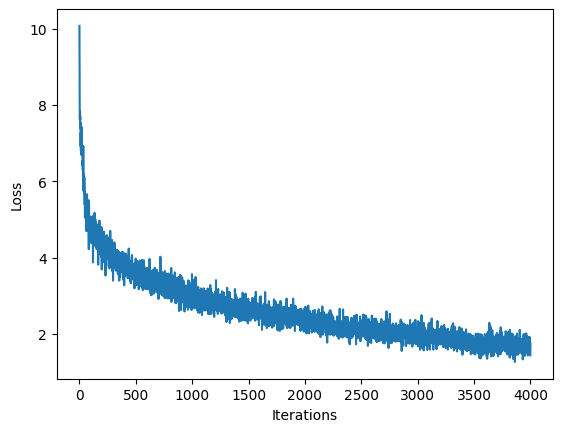

In [52]:
plt.plot(loss_list_tlm)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

Generate an unconditional sample of length `context_window_size` from your trained `TransformerLM`, and also prompt it with the two prompts we gave you. How does the output look? Discuss?

In [53]:
# the contexts for the different prompts
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(f"shape is {start_context.shape}")
context1 = torch.tensor(from_code_bert(tokenizer.encode(prompt_1_text)[:-1]), device=device).reshape(1, -1) # (1, T)
print(f"shape is {context1.shape}")
context2 = torch.tensor(from_code_bert(tokenizer.encode(prompt_2_text)[:-1])).to(device).reshape(1, -1)
print(f"shape is {context2.shape}")

shape is torch.Size([1, 1])
shape is torch.Size([1, 225])
shape is torch.Size([1, 263])


In [54]:
# unconditional generate from the transformer model
uncond_gen = (tlm.generate(start_context, max_new_tokens=context_window_size)[0].tolist())
print(tokenizer.decode(to_code_bert(uncond_gen)))

<s>#!/usr/license-negative/sr
import requests.bin
import json-'


def stFileize():
     url = f'{http://localhostmap(uuid.irport)}\array\n'

    animal = os.se 9000
    data = data.read(r, myer, login)

    returnnd

with open('h', '/where.json') as f:
    def rv(len, loop):
        yieldel

    dt = [f for x in size:
            f.rotation()
    raise TypeError()

    print('all required uri' ')

    for x, v) in file.items():
        res = list()
        None
        result = svti()
        print(top + b)
    else:
        # Config from config action():


In [61]:
# generate from the prompts
gen_1 = tlm.generate(context1, max_new_tokens=context_window_size, temperature=.8)
gen_2 = tlm.generate(context2, max_new_tokens=context_window_size, temperature=.8)
# decode the generated tokens
gen_1_text = tokenizer.decode(to_code_bert(gen_1[0].cpu().numpy()))
gen_2_text = tokenizer.decode(to_code_bert(gen_2[0].cpu().numpy()))

In [62]:
print(f"generated text from prompt 1: {gen_1_text}")

generated text from prompt 1: <s>def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):
    l1 = lexporter.get_for_info()
    with pytest.raises(
        "AtesVal`Eets if run):
        return

    if n:
        # handle the def for 0
        raise ValueError(
            self.eb1, self.cuda_check, r1.get_consumer("a"), params)
    # get 

In [63]:
# conditional generation of cosine distance
print(f"generated text from prompt 2: {gen_2_text}")

generated text from prompt 2: <s>import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):
    """
    Returns a yps results = []

    assert R.MC_RTS

    # Check that the function we check all
    # classification elements that is case
    if we.

     orange_sqrtd(z) in pear331/256, zeta1, and reduce
    # cycle are want
    def test_start_view(self):
        x, y = draw_transargs(self.num_grad, x, other_features, angle=np.sy))
        x =conv * np.random.randint(0, 3, 5))
        x = x * x
 

### Part 1(b): Transformer with Swish

In [ ]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForwardSwish(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.SiLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class TransformerBlockSwish(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, block_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForwardSwish(embed_size)
        head_size = embed_size // num_heads
        self.mh_attention = MultiHeadAttention(vocab_size, block_size,
                                                 num_heads, head_size,
                                                 embed_size=384)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [ ]:
class TransformerSwishLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlockSwish(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])
        self.context_window_size = context_window_size

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)


        # Start of my code
        logits = self.lm_head(self.ln_f(self.blocks(x))) # (B, T, V) # able to put all in one step because of sequential
        if targets is None:
            loss = None
        else:
            logits_for_loss = logits.view(B*T, -1) # could do -1 here, but doing explicitly for clarity
            targets_for_loss = targets.view(B*T)
            loss = F.cross_entropy(logits_for_loss, targets_for_loss) # default reduction is mean, so we don't need to average

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens, temperature=1.0):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # done
        generated_tokens = token_ids
        for _ in range(max_new_tokens):
            in_window = generated_tokens[:, -self.context_window_size:] # (B, T)
            # Get the logits for the current sequence
            logits, _ = self.forward(in_window)  # (B, T_current, V)
            # Select the last token logits
            next_token_logits = logits[:, -1, :]  # (B, V)
            next_token = temperature_sampling(next_token_logits, temperature)  # Sample a new token
            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)  # (B, T_current + 1)
        return generated_tokens

In [ ]:
trans_swish = TransformerSwishLM(vocab_size, context_window_size)
tlm_swish = trans_swish.to(device)

In [ ]:
loss_list_tlm, loss_eval_tlm = train_or_load_model(save_dir,
                                                     tlm_swish,
                                                     "tlm_swish",
                                                     learning_rate = 1e-4,
                                                     iters = 4000,
                                                     eval_iters = 400,
                                                     context_window_size = context_window_size,
                                                     device = device)

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the python code dataset by encoding text into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generate code output.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate in the style of python code syntax, although there are many quirks that suggest it will not make a very practical code assistant in its current state.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but it is up to you to state precisely in what sense your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not constitue an improvement according to your definition.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands, but must be based on the goal of improving the model by more efficiently learning from our data.

_Hints_: There are many aspects to assessing our model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. One of your apprendices should contain a link to any code used to generate the project so that we can grade it (google drive with colab nbs or github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

### Data augmentation

We got the data for this project from [The Stack](https://huggingface.co/datasets/bigcode/the-stack-dedup). If you'd like, you can definitely train on larger datasets by accessing their dataset of python code (we just scratched the surface). You have to make an account on Hugginface to get a Hugginface access token, but the process is pretty quick.

# S4 Mamba

## General Idea

We want to implement [Mamba](https://arxiv.org/abs/2312.00752). This is a new way of thinking about long range sequence modeling and as such we will be expanding our view beyond simply saying "let's connect everything and see what happens." I view Mamba as a reasonable comparison to Transformers because they are both adapted to the GPU and take full advantage of them. We will first implement S4 Mamba and then attempt to do some purturbations of the idea.

I will attempt to follow, as closely as possible, the notation of the original paper while still following Python Conventions.

Generally Mamba is taking the original S4 layers and enabling Time variance. S5 could do this well but all of the code is in JAX which seems hard to write in (at least for me right now). I want to get a working Mamba model and then see if I can build on it.

I also want to move this to JAX at some point, but first I will just implement it in PyTorch because I know that better (I tried to do JAX but it was hard at first)

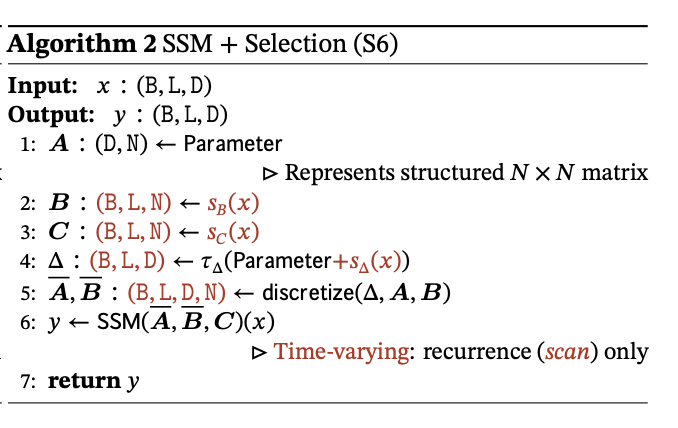

This algorithm

I never would have been able to come up with this implementation of selective scan. This is magic. I am in awe.

#### MAGIC

In [10]:
# Copyright (c) 2023, Tri Dao, Albert Gu.

try:
    from causal_conv1d import causal_conv1d_fn
    import causal_conv1d_cuda
except ImportError:
    causal_conv1d_fn = None
    causal_conv1d_cuda = None

import selective_scan_cuda


class SelectiveScanFn(torch.autograd.Function):

    @staticmethod
    def forward(ctx, u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                return_last_state=False):
        if u.stride(-1) != 1:
            u = u.contiguous()
        if delta.stride(-1) != 1:
            delta = delta.contiguous()
        if D is not None:
            D = D.contiguous()
        if B.stride(-1) != 1:
            B = B.contiguous()
        if C.stride(-1) != 1:
            C = C.contiguous()
        if z is not None and z.stride(-1) != 1:
            z = z.contiguous()
        if B.dim() == 3:
            B = rearrange(B, "b dstate l -> b 1 dstate l")
            ctx.squeeze_B = True
        if C.dim() == 3:
            C = rearrange(C, "b dstate l -> b 1 dstate l")
            ctx.squeeze_C = True
        out, x, *rest = selective_scan_cuda.fwd(u, delta, A, B, C, D, z, delta_bias, delta_softplus)
        ctx.delta_softplus = delta_softplus
        ctx.has_z = z is not None
        last_state = x[:, :, -1, 1::2]  # (batch, dim, dstate)
        if not ctx.has_z:
            ctx.save_for_backward(u, delta, A, B, C, D, delta_bias, x)
            return out if not return_last_state else (out, last_state)
        else:
            ctx.save_for_backward(u, delta, A, B, C, D, z, delta_bias, x, out)
            out_z = rest[0]
            return out_z if not return_last_state else (out_z, last_state)

    @staticmethod
    def backward(ctx, dout, *args):
        if not ctx.has_z:
            u, delta, A, B, C, D, delta_bias, x = ctx.saved_tensors
            z = None
            out = None
        else:
            u, delta, A, B, C, D, z, delta_bias, x, out = ctx.saved_tensors
        if dout.stride(-1) != 1:
            dout = dout.contiguous()
        # The kernel supports passing in a pre-allocated dz (e.g., in case we want to fuse the
        # backward of selective_scan_cuda with the backward of chunk).
        # Here we just pass in None and dz will be allocated in the C++ code.
        du, ddelta, dA, dB, dC, dD, ddelta_bias, *rest = selective_scan_cuda.bwd(
            u, delta, A, B, C, D, z, delta_bias, dout, x, out, None, ctx.delta_softplus,
            False  # option to recompute out_z, not used here
        )
        dz = rest[0] if ctx.has_z else None
        dB = dB.squeeze(1) if getattr(ctx, "squeeze_B", False) else dB
        dC = dC.squeeze(1) if getattr(ctx, "squeeze_C", False) else dC
        return (du, ddelta, dA, dB, dC,
                dD if D is not None else None,
                dz,
                ddelta_bias if delta_bias is not None else None,
                None,
                None)


def selective_scan_fn(u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                     return_last_state=False):
    """if return_last_state is True, returns (out, last_state)
    last_state has shape (batch, dim, dstate). Note that the gradient of the last state is
    not considered in the backward pass.
    """
    return SelectiveScanFn.apply(u, delta, A, B, C, D, z, delta_bias, delta_softplus, return_last_state)


def selective_scan_ref(u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                      return_last_state=False):
    """
    u: r(B D L)
    delta: r(B D L)
    A: c(D N) or r(D N)
    B: c(D N) or r(B N L) or r(B N 2L) or r(B G N L) or (B G N L)
    C: c(D N) or r(B N L) or r(B N 2L) or r(B G N L) or (B G N L)
    D: r(D)
    z: r(B D L)
    delta_bias: r(D), fp32

    out: r(B D L)
    last_state (optional): r(B D dstate) or c(B D dstate)
    """
    dtype_in = u.dtype
    u = u.float()
    delta = delta.float()
    if delta_bias is not None:
        delta = delta + delta_bias[..., None].float()
    if delta_softplus:
        delta = F.softplus(delta)
    batch, dim, dstate = u.shape[0], A.shape[0], A.shape[1]
    is_variable_B = B.dim() >= 3
    is_variable_C = C.dim() >= 3
    if A.is_complex():
        if is_variable_B:
            B = torch.view_as_complex(rearrange(B.float(), "... (L two) -> ... L two", two=2))
        if is_variable_C:
            C = torch.view_as_complex(rearrange(C.float(), "... (L two) -> ... L two", two=2))
    else:
        B = B.float()
        C = C.float()
    x = A.new_zeros((batch, dim, dstate))
    ys = []
    deltaA = torch.exp(torch.einsum('bdl,dn->bdln', delta, A))
    if not is_variable_B:
        deltaB_u = torch.einsum('bdl,dn,bdl->bdln', delta, B, u)
    else:
        if B.dim() == 3:
            deltaB_u = torch.einsum('bdl,bnl,bdl->bdln', delta, B, u)
        else:
            B = repeat(B, "B G N L -> B (G H) N L", H=dim // B.shape[1])
            deltaB_u = torch.einsum('bdl,bdnl,bdl->bdln', delta, B, u)
    if is_variable_C and C.dim() == 4:
        C = repeat(C, "B G N L -> B (G H) N L", H=dim // C.shape[1])
    last_state = None
    for i in range(u.shape[2]):
        x = deltaA[:, :, i] * x + deltaB_u[:, :, i]
        if not is_variable_C:
            y = torch.einsum('bdn,dn->bd', x, C)
        else:
            if C.dim() == 3:
                y = torch.einsum('bdn,bn->bd', x, C[:, :, i])
            else:
                y = torch.einsum('bdn,bdn->bd', x, C[:, :, :, i])
        if i == u.shape[2] - 1:
            last_state = x
        if y.is_complex():
            y = y.real * 2
        ys.append(y)
    y = torch.stack(ys, dim=2) # (batch dim L)
    out = y if D is None else y + u * rearrange(D, "d -> d 1")
    if z is not None:
        out = out * F.silu(z)
    out = out.to(dtype=dtype_in)
    return out if not return_last_state else (out, last_state)


class MambaInnerFn(torch.autograd.Function):

    @staticmethod
    @custom_fwd
    def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
                out_proj_weight, out_proj_bias,
                A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
                C_proj_bias=None, delta_softplus=True, checkpoint_lvl=1):
        """
             xz: (batch, dim, seqlen)
        """
        assert causal_conv1d_cuda is not None, "causal_conv1d_cuda is not available. Please install causal-conv1d."
        assert checkpoint_lvl in [0, 1]
        L = xz.shape[-1]
        delta_rank = delta_proj_weight.shape[1]
        d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
        if torch.is_autocast_enabled():
            x_proj_weight = x_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            delta_proj_weight = delta_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            out_proj_weight = out_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            out_proj_bias = (out_proj_bias.to(dtype=torch.get_autocast_gpu_dtype())
                             if out_proj_bias is not None else None)
        if xz.stride(-1) != 1:
            xz = xz.contiguous()
        conv1d_weight = rearrange(conv1d_weight, "d 1 w -> d w")
        x, z = xz.chunk(2, dim=1)
        conv1d_bias = conv1d_bias.contiguous() if conv1d_bias is not None else None
        conv1d_out = causal_conv1d_cuda.causal_conv1d_fwd(
            x, conv1d_weight, conv1d_bias, None, None, None, True
        )
        # We're being very careful here about the layout, to avoid extra transposes.
        # We want delta to have d as the slowest moving dimension
        # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
        x_dbl = F.linear(rearrange(conv1d_out, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
        delta = rearrange(delta_proj_weight @ x_dbl[:, :delta_rank].t(), "d (b l) -> b d l", l = L)
        ctx.is_variable_B = B is None
        ctx.is_variable_C = C is None
        ctx.B_proj_bias_is_None = B_proj_bias is None
        ctx.C_proj_bias_is_None = C_proj_bias is None
        if B is None:  # variable B
            B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl dstate)
            if B_proj_bias is not None:
                B = B + B_proj_bias.to(dtype=B.dtype)
            if not A.is_complex():
                # B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
                B = rearrange(B, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            else:
                B = rearrange(B, "(b l) (dstate two) -> b 1 dstate (l two)", l=L, two=2).contiguous()
        else:
            if B.stride(-1) != 1:
                B = B.contiguous()
        if C is None:  # variable C
            C = x_dbl[:, -d_state:]  # (bl dstate)
            if C_proj_bias is not None:
                C = C + C_proj_bias.to(dtype=C.dtype)
            if not A.is_complex():
                # C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
                C = rearrange(C, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            else:
                C = rearrange(C, "(b l) (dstate two) -> b 1 dstate (l two)", l=L, two=2).contiguous()
        else:
            if C.stride(-1) != 1:
                C = C.contiguous()
        if D is not None:
            D = D.contiguous()
        out, scan_intermediates, out_z = selective_scan_cuda.fwd(
            conv1d_out, delta, A, B, C, D, z, delta_bias, delta_softplus
        )
        ctx.delta_softplus = delta_softplus
        ctx.out_proj_bias_is_None = out_proj_bias is None
        ctx.checkpoint_lvl = checkpoint_lvl
        if checkpoint_lvl >= 1:  # Will recompute conv1d_out and delta in the backward pass
            conv1d_out, delta = None, None
        ctx.save_for_backward(xz, conv1d_weight, conv1d_bias, x_dbl, x_proj_weight,
                              delta_proj_weight, out_proj_weight, conv1d_out, delta,
                              A, B, C, D, delta_bias, scan_intermediates, out)
        return F.linear(rearrange(out_z, "b d l -> b l d"), out_proj_weight, out_proj_bias)

    @staticmethod
    @custom_bwd
    def backward(ctx, dout):
        # dout: (batch, seqlen, dim)
        assert causal_conv1d_cuda is not None, "causal_conv1d_cuda is not available. Please install causal-conv1d."
        (xz, conv1d_weight, conv1d_bias, x_dbl, x_proj_weight, delta_proj_weight, out_proj_weight,
         conv1d_out, delta, A, B, C, D, delta_bias, scan_intermediates, out) = ctx.saved_tensors
        L = xz.shape[-1]
        delta_rank = delta_proj_weight.shape[1]
        d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
        x, z = xz.chunk(2, dim=1)
        if dout.stride(-1) != 1:
            dout = dout.contiguous()
        if ctx.checkpoint_lvl == 1:
            conv1d_out = causal_conv1d_cuda.causal_conv1d_fwd(
                x, conv1d_weight, conv1d_bias, None, None, None, True
            )
            delta = rearrange(delta_proj_weight @ x_dbl[:, :delta_rank].t(),
                              "d (b l) -> b d l", l = L)
        # The kernel supports passing in a pre-allocated dz (e.g., in case we want to fuse the
        # backward of selective_scan_cuda with the backward of chunk).
        dxz = torch.empty_like(xz)  # (batch, dim, seqlen)
        dx, dz = dxz.chunk(2, dim=1)
        dout = rearrange(dout, "b l e -> e (b l)")
        dout_y = rearrange(out_proj_weight.t() @ dout, "d (b l) -> b d l", l=L)
        dconv1d_out, ddelta, dA, dB, dC, dD, ddelta_bias, dz, out_z = selective_scan_cuda.bwd(
            conv1d_out, delta, A, B, C, D, z, delta_bias, dout_y, scan_intermediates, out, dz,
            ctx.delta_softplus,
            True  # option to recompute out_z
        )
        dout_proj_weight = torch.einsum("eB,dB->ed", dout, rearrange(out_z, "b d l -> d (b l)"))
        dout_proj_bias = dout.sum(dim=(0, 1)) if not ctx.out_proj_bias_is_None else None
        dD = dD if D is not None else None
        dx_dbl = torch.empty_like(x_dbl)
        dB_proj_bias = None
        if ctx.is_variable_B:
            if not A.is_complex():
                dB = rearrange(dB, "b 1 dstate l -> (b l) dstate").contiguous()
            else:
                dB = rearrange(dB, "b 1 dstate (l two) -> (b l) (dstate two)", two=2).contiguous()
            dB_proj_bias = dB.sum(0) if not ctx.B_proj_bias_is_None else None
            dx_dbl[:, delta_rank:delta_rank + d_state] = dB  # (bl d)
            dB = None
        dC_proj_bias = None
        if ctx.is_variable_C:
            if not A.is_complex():
                dC = rearrange(dC, "b 1 dstate l -> (b l) dstate").contiguous()
            else:
                dC = rearrange(dC, "b 1 dstate (l two) -> (b l) (dstate two)", two=2).contiguous()
            dC_proj_bias = dC.sum(0) if not ctx.C_proj_bias_is_None else None
            dx_dbl[:, -d_state:] = dC  # (bl d)
            dC = None
        ddelta = rearrange(ddelta, "b d l -> d (b l)")
        ddelta_proj_weight = torch.einsum("dB,Br->dr", ddelta, x_dbl[:, :delta_rank])
        dx_dbl[:, :delta_rank] = torch.einsum("dB,dr->Br", ddelta, delta_proj_weight)
        dconv1d_out = rearrange(dconv1d_out, "b d l -> d (b l)")
        dx_proj_weight = torch.einsum("Br,Bd->rd", dx_dbl, rearrange(conv1d_out, "b d l -> (b l) d"))
        dconv1d_out = torch.addmm(dconv1d_out, x_proj_weight.t(), dx_dbl.t(), out=dconv1d_out)
        dconv1d_out = rearrange(dconv1d_out, "d (b l) -> b d l", b=x.shape[0], l=x.shape[-1])
        # The kernel supports passing in a pre-allocated dx (e.g., in case we want to fuse the
        # backward of conv1d with the backward of chunk).
        dx, dconv1d_weight, dconv1d_bias, *_ = causal_conv1d_cuda.causal_conv1d_bwd(
            x, conv1d_weight, conv1d_bias, dconv1d_out, None, None, None, dx, False, True
        )
        dconv1d_bias = dconv1d_bias if conv1d_bias is not None else None
        dconv1d_weight = rearrange(dconv1d_weight, "d w -> d 1 w")
        return (dxz, dconv1d_weight, dconv1d_bias, dx_proj_weight, ddelta_proj_weight,
                dout_proj_weight, dout_proj_bias,
                dA, dB, dC, dD,
                ddelta_bias if delta_bias is not None else None,
                dB_proj_bias, dC_proj_bias, None)


def mamba_inner_fn(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True
):
    return MambaInnerFn.apply(xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
                              out_proj_weight, out_proj_bias,
                              A, B, C, D, delta_bias, B_proj_bias, C_proj_bias, delta_softplus)


def mamba_inner_ref(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True
):
    assert causal_conv1d_fn is not None, "causal_conv1d_fn is not available. Please install causal-conv1d."
    L = xz.shape[-1]
    delta_rank = delta_proj_weight.shape[1]
    d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
    x, z = xz.chunk(2, dim=1)
    x = causal_conv1d_fn(x, rearrange(conv1d_weight, "d 1 w -> d w"), conv1d_bias, activation="silu")
    # We're being very careful here about the layout, to avoid extra transposes.
    # We want delta to have d as the slowest moving dimension
    # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
    x_dbl = F.linear(rearrange(x, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
    delta = delta_proj_weight @ x_dbl[:, :delta_rank].t()
    delta = rearrange(delta, "d (b l) -> b d l", l=L)
    if B is None:  # variable B
        B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl d)
        if B_proj_bias is not None:
            B = B + B_proj_bias.to(dtype=B.dtype)
        if not A.is_complex():
            B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            B = rearrange(B, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    if C is None:  # variable B
        C = x_dbl[:, -d_state:]  # (bl d)
        if C_proj_bias is not None:
            C = C + C_proj_bias.to(dtype=C.dtype)
        if not A.is_complex():
            C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            C = rearrange(C, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    y = selective_scan_fn(x, delta, A, B, C, D, z=z, delta_bias=delta_bias, delta_softplus=True)
    return F.linear(rearrange(y, "b d l -> b l d"), out_proj_weight, out_proj_bias)

#### Back to normal people land

In [15]:
# instead of tracking all the parameters, we will just use a dataclass
@dataclass
class MambaConfig:
    embed_size: int # hidden layer size
    n_layers: int # number of layers
    vocab_size: int # number of tokens in the vocabulary
    ssm_dim: int = 16 # N in the above, dimension of implicit latent state
    expansion_factor: int = 2 # expansion factor (E in 3.4)
    # d_expanded: int # E*embed_size, the expanded dimension
    conv_kernel_size: int = 4 # kernel size for the convolutional layer
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True # whether to use bias in the convolutional layer
    bias: bool = False # whether to use bias in the linear layers
    context_window_size: int = context_window_size # should be able to increase this above transformer
    device: str = "cuda" # device to use
    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init_floor: float =1e-4
    dt_init: str = "random"
    dt_scale: float = 1.0

    def __post_init__(self):
        self.device = get_device()
        self.d_expanded = self.embed_size * self.expansion_factor
        self.delta_rank = math.ceil(self.embed_size / self.ssm_dim)

In [18]:
class MambaSingleBlock(nn.Module):
    """Mamba the heart of the Mamba model
        Implements the S4 layer with the SSM and the Convolutional layer
        Just does exactly what is given in Figure 3 of the paper"""
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config

        self.maketwocopies = nn.Linear(config.embed_size,
                                       config.d_expanded*2,
                                       bias=config.bias)

        self.conv = nn.Conv1d(in_channels=config.d_expanded,
                              out_channels=config.d_expanded,
                              kernel_size=config.conv_kernel_size,
                              padding=config.conv_kernel_size - 1,
                              groups=config.d_expanded,
                              bias=config.conv_bias)

        self.activation = "silu"
        self.act = nn.SiLU()

        # in original paper, uses "x_proj" and "dt_proj"
        # This linear layer is how we get
        # delta, B and C, which are the main parameters of the SSM
        # B and C are (clearly) input dependent. A is not, it is the
        # coefficient on the hidden state in the PDE for the hidden state
        self.x_proj = nn.Linear(config.d_expanded,
                                config.delta_rank + config.ssm_dim * 2,
                                bias=config.bias)

        # projects the low rank delta to the dimension of all the parameters
        self.dt_proj = nn.Linear(config.delta_rank,
                                   config.d_expanded,
                                   bias=True)


        # Shamelessly copied from the paper's implementation:
        # They use a custom initialization for both
        # Initialize special dt projection to preserve variance at initialization
        dt_init_std = config.delta_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # They use a custom initialization for the dt_proj bias
        # Initialize dt bias so that F.softplus(dt_bias) is between dt_min and dt_max
        dt = torch.exp(
            torch.rand(config.d_expanded) * (math.log(config.dt_max) - math.log(config.dt_min))
            + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # Our initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        self.dt_proj.bias._no_reinit = True

        # Now we make the diagonal $A$ matrix,
        # Making it diagonal cause Jimmy told me to
        # We use the log of A for numerical stability
        A = repeat(
            torch.arange(1, config.ssm_dim + 1, dtype=torch.float32, device=device),
            "n -> d n",
            d=config.d_expanded,
        ).contiguous()
        A_log = torch.log(A)  # Keep A_log in fp32
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True # done in original paper

        # D "skip" parameter
        self.D = nn.Parameter(torch.ones(config.d_expanded, device=device))  # Keep in fp32
        self.D._no_weight_decay = True # done in original paper

        self.out_proj = nn.Linear(self.d_expanded, self.embed_size, bias=config.bias)
        # finally done with init and defs

    def forward(self, x):
        """
        input is (b, l, d)
        output is (b, l, d)
        """
        batch, seqlen, dim = x.shape

        conv_state, ssm_state = None, None
        # we need to make two copies of the input
        # this is the first step in the S4 layer
        x = self.maketwocopies(x)
        x, resid = x.split(split_size=[self.config.d_expanded,
                                       self.config.d_expanded],
                           dim=-1)

        # here we lose some of the cool implementation of the original
        # to get some interpretability of the code
        x = rearrange(x, "b l d -> b d l")
        x = self.conv(x)[:, :, :seqlen]
        x.rearrange(x, "b d l -> b l d")
        x = self.act(x)
        y = self.ssmlayer(x)
        y = y * self.act(resid)
        out = self.out_proj(y)
        return out

    def ssmlayer(self, x):
        """
        This function is the SSM layer, the heart of the Mamba model
        it is Algorithm 2 in the paper (shown above)
        input is (b, l, d)
        output is (b, l, d)
        """
        d_expand, ssm_dim_inlayer = self.A_log.shape

        # Now we get the parameters for the SSM

        A = -torch.exp(self.A_log) # (d, N)
        delta, B, C = self.x_proj(x).split([self.delta_rank, self.ssm_dim, self.ssm_dim],
                                           dim=-1) # (b, l, dt_rank), (b, l, N), (b, l, N)
        delta = F.softplus(self.dt_proj(delta)) # (b, l, d)

        # now run the selective scan, using the parameters we just got
        y = selective_scan_fn(
                x,
                delta,
                A,
                B,
                C,
                self.D.float(),
                z=z,
                delta_bias=self.dt_proj.bias.float(),
                delta_softplus=True,
                return_last_state=ssm_state is not None,
            )
            if ssm_state is not None:
                y, last_state = y
                ssm_state.copy_(last_state)
            y = rearrange(y, "b d l -> b l d")
            out = self.out_proj(y)
        return out

    # def selective_scan(self, x, delta, A, B, C, D):
    #     """
    #     This function is the selective scan, the heart of the SSM layer
    #     """

SyntaxError: incomplete input (<ipython-input-18-8181368d890e>, line 129)

In [19]:
class MambaBlock(nn.Module):
  """
    Mamba block: Just a wrapper for the mamba block with Conv and SSM,
    with some layer norm and residual connections mixed in
    Uses MambaSingleBlock to do the actual work
    Note the original paper uses RMSNorm, but I will use LayerNorm for now
  """

  def __init__(self, config: MambaConfig):
      super().__init__()
      self.config = config
      self.ln = nn.LayerNorm(config.embed_size)
      self.mambaApplication = MambaSingleBlock(config)

  def forward(self, x):
    """
      input is (b, l , d)
      output is (b, l, d)
    """
    x = x + self.mambaApplication(self.ln(x))
    return x

In [20]:
class Mamba(nn.Module):
    def __init__(self, config: MambaConfig):
        """
        Implementation of Mamba model, using MambaBlock and with
        Layer Norm and Residual connections like Transformer Implementation
        Uses Swish activation (like original paper)
        """
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.vocab_size,
                                                  config.embed_size)
        self.blocks = nn.Sequential(*[
            MambaBlock(config)
            for _ in range(config.n_layers)])
        self.ln_f = nn.LayerNorm(config.embed_size)

        self.lm_head = nn.Linear(args.d_model, args.vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # Tie output projection to embedding weights.
                                                     # See "Weight Tying" paper


    def forward(self, input_ids):
        """
        Args:
            input_ids (long tensor): shape (b, l)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            logits: shape (b, l, vocab_size)

        Official Implementation:
            class MambaLMHeadModel, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py#L173

        """
        x = self.embedding(input_ids)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)
        logits = self.lm_head(x)

        return logits